# KAN-ODE

## KODE网络训练

### 安装依赖

In [1]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [3]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  # 用于记录neural_output

    def forward(self, t, y):
        S, I, R, A = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  # 记录neural_output
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        dA_dt = abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])

### 初始化模型参数

In [4]:
gamma = 0.005
beta = 2 * gamma  #根据实际情况，参数beta是参数gamma的具体倍数
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [5]:
intial = 0.  ##时间区间的初始值
last= 100.    ##时间区间的终值
step = 100   ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 无扰动部分

#### 生成真实数据

In [6]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

#### 定义损失函数
##### 使用仅与I相关的损失函数

In [7]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

#### 定义准确率计算函数
##### 使用仅与I相关的准确率函数

In [8]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

#### 定义差分机计算公式

In [9]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

#### 定义训练模型
##### 执行模型的训练

In [10]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(2000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

#### 进行训练

In [11]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.07129943370819092, Accuracy: 3.00%


##### 将A进行差分

In [ ]:
True_y[:,3] = forword_CF(True_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_900059/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [ ]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': True_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],

}

dft = pd.DataFrame(tdata)

##### 保存成Excel文件

In [ ]:
dft.to_excel('ZS-t.xlsx', index=False)

### 加扰动部分
#### 生成真实数据

In [ ]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

#### 加入噪声

##### 泊松分布的噪声

In [ ]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = y * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

#### 进行训练

In [ ]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 5.800071085104719e-05, Accuracy: 86.25%
Iter 100, Loss: 4.997464202460833e-05, Accuracy: 88.75%
Iter 200, Loss: 4.9149803089676425e-05, Accuracy: 87.50%
Iter 300, Loss: 4.898411134490743e-05, Accuracy: 88.75%
Iter 400, Loss: 4.8939815314952284e-05, Accuracy: 88.75%
Iter 500, Loss: 4.886346869170666e-05, Accuracy: 88.75%
Iter 600, Loss: 4.876522143604234e-05, Accuracy: 88.75%
Iter 700, Loss: 4.865151277044788e-05, Accuracy: 88.75%
Iter 800, Loss: 4.8548557970207185e-05, Accuracy: 88.75%
Iter 900, Loss: 4.844239083467983e-05, Accuracy: 88.75%
Iter 1000, Loss: 4.833436105400324e-05, Accuracy: 88.75%
Iter 1100, Loss: 4.822613482247107e-05, Accuracy: 88.75%
Iter 1200, Loss: 4.81197566841729e-05, Accuracy: 88.75%
Iter 1300, Loss: 4.8009420424932614e-05, Accuracy: 88.75%
Iter 1400, Loss: 4.789916056324728e-05, Accuracy: 88.75%
Iter 1500, Loss: 4.778043148689903e-05, Accuracy: 88.75%
Iter 1600, Loss: 4.7663743316661566e-05, Accuracy: 88.75%
Iter 1700, Loss: 4.7547586291329935e-05

##### 泊松分布扰动

In [ ]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = True_y[:,3] * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
Z_true_y[:,3] = poisson_noise/10000

##### 差分计算

In [ ]:
Z_pred_y[:,3] = forword_CF(Z_pred_y[:,3])

/tmp/ipykernel_900059/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [ ]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],
    'True_A': Z_true_y.numpy()[:, 3],
    'Predicted_A': Z_pred_y.detach().numpy()[:, 3],
}

dft = pd.DataFrame(tdata)



##### 保存成Excel文件

In [ ]:
dft.to_excel('ZS-zt.xlsx', index=False)

### 绘制结果并将图片结果保存
#### 训练阶段可视化

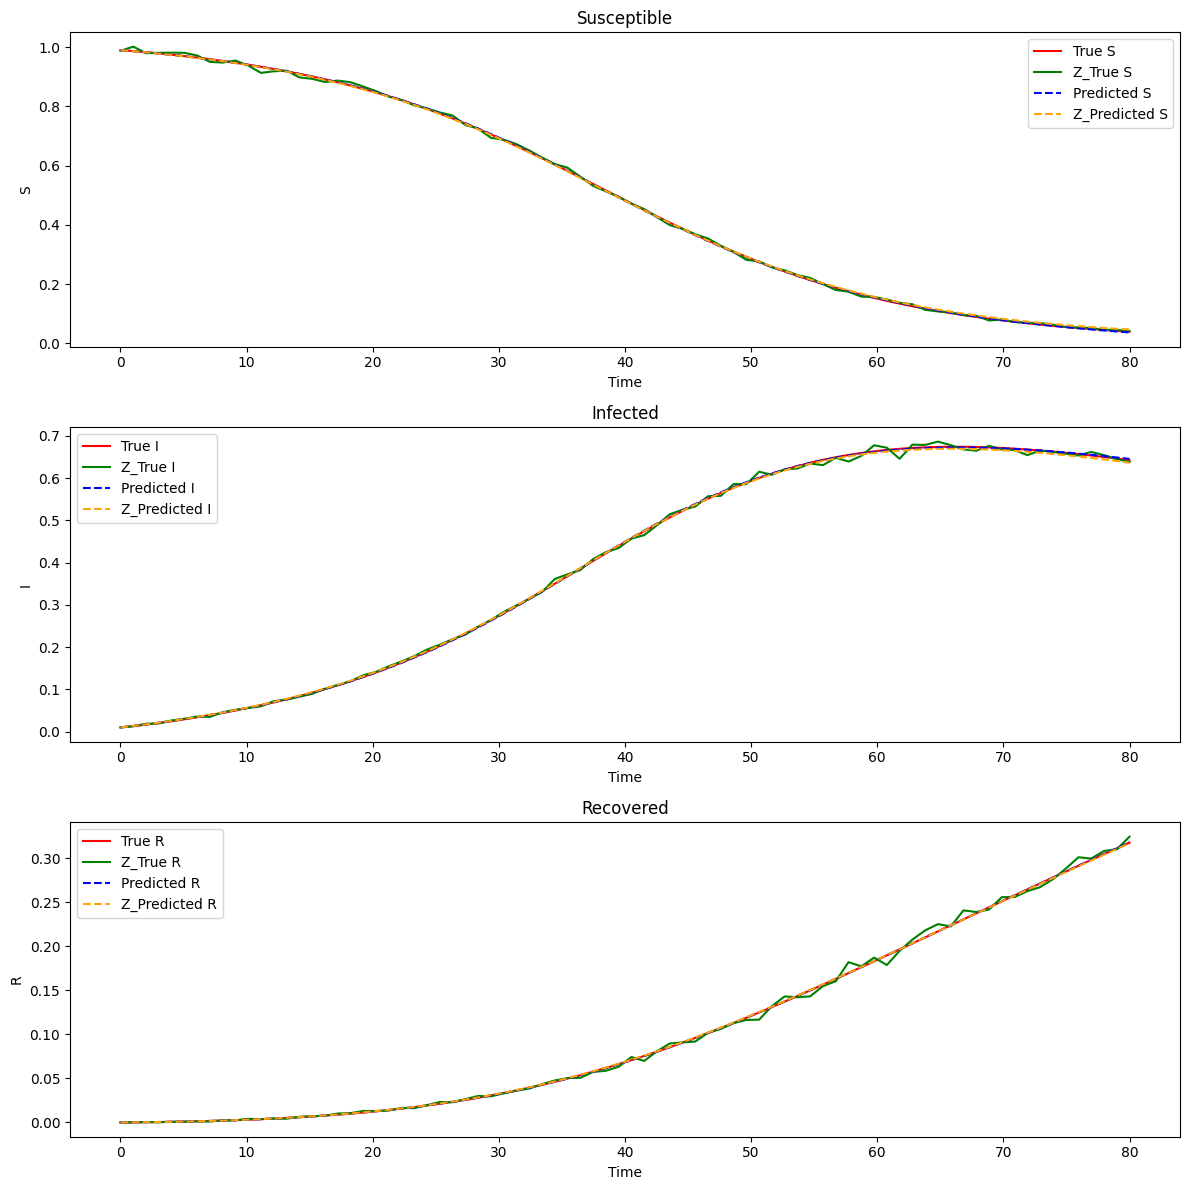

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()


##### 真实数据可视化

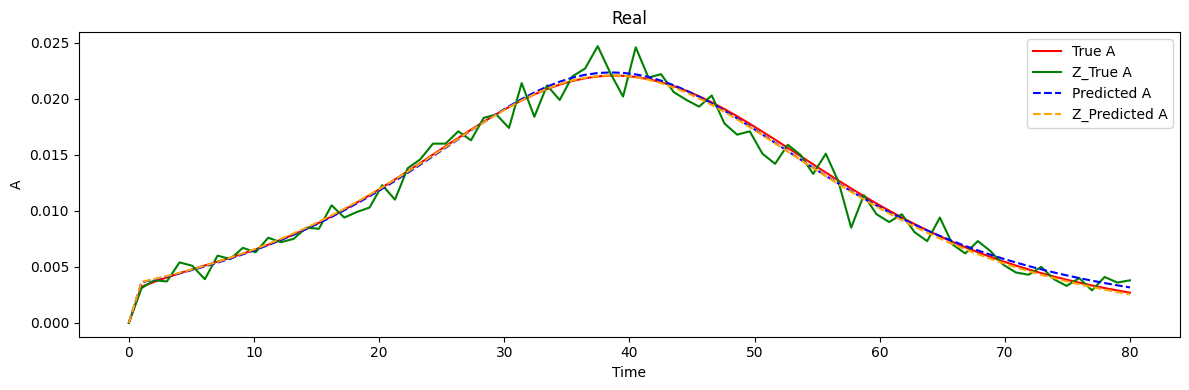

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(t.numpy(), True_y.numpy()[:, 3], '-', label='True A', color='red')
plt.plot(t.numpy(), Z_true_y.detach().numpy()[:, 3], '-', label='Z_True A', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], '--', label='Predicted A', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 3], '--', label='Z_Predicted A', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')


plt.tight_layout()
plt.show()